In [2]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
import hdbscan
import pickle
import pandas as pd
import umap
import matplotlib.pyplot as plt


/home/ignacioargel/.cache/pypoetry/virtualenvs/pow_a_pos-Du1pSIFd-py3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-04 21:58:15.418291: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-04 21:58:15.418373: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-04 21:58:15.418422: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-04 21:58:15.433057: I tensorflow/core/platform/cp

In [3]:
df_trx = pd.read_csv('../../results/2024-03-04 21:54:34_b4723aa0/fake_graph.csv')
df_trx

,from_address,to_address,cluster_from,cluster_to,block_timestamp,value
0,0b9c91bc-e488-4ea8-ba0a-4044d86731e6,ead17feb-6308-48c7-b9be-e995dfad0a8e,3,1,1,163.045697
1,bebee3f7-aa19-4c97-8dfa-ca63321a56cf,a04ae29b-fb2e-4183-9082-a211cee57035,2,3,1,193.394443
2,be201540-a533-4f40-9a65-1ef03ede15f6,72ae13e9-f3d0-462f-8d65-2d4783438a0e,2,3,1,179.412906
3,fda79b8d-fc54-40c7-8923-ddd9bb846426,46df4841-e059-4a86-93e7-76e8b78bbf94,2,3,1,73.289300
4,fa35fb4c-dcbd-4231-a136-c9eeab0c77ad,fa35fb4c-dcbd-4231-a136-c9eeab0c77ad,0,0,1,293.503660
...,...,...,...,...,...,...
3995,8a65bbf4-d2be-4492-aa67-bf49a2547ebb,e1381a88-df9a-4e7f-bf8e-cfcf47bed842,0,0,1,399.548312
3996,e1381a88-df9a-4e7f-bf8e-cfcf47bed842,b3928a6a-eda9-4e65-9044-abb58ec38180,0,0,1,7.407380
3997,670965cc-5acc-4496-990f-32a704712787,0621c3d2-4ce0-4398-a15c-0aaf7a3c719c,3,0,1,143.813887
3998,edc38db1-1ac4-4eef-be32-b0613d5bdfd5,edc38db1-1ac4-4eef-be32-b0613d5bdfd5,1,1,1,282.151784


In [7]:
clusters = dict()

def set_clusters(row, clusters):
    clusters[row.from_address] = row.cluster_from
    clusters[row.to_address] = row.cluster_to

df_trx.apply(lambda x: set_clusters(x, clusters), axis=1)
clusters

{'0b9c91bc-e488-4ea8-ba0a-4044d86731e6': 3,
 'ead17feb-6308-48c7-b9be-e995dfad0a8e': 1,
 'bebee3f7-aa19-4c97-8dfa-ca63321a56cf': 2,
 'a04ae29b-fb2e-4183-9082-a211cee57035': 3,
 'be201540-a533-4f40-9a65-1ef03ede15f6': 2,
 '72ae13e9-f3d0-462f-8d65-2d4783438a0e': 3,
 'fda79b8d-fc54-40c7-8923-ddd9bb846426': 2,
 '46df4841-e059-4a86-93e7-76e8b78bbf94': 3,
 'fa35fb4c-dcbd-4231-a136-c9eeab0c77ad': 0,
 '271ca8e3-13b7-44d3-b064-baac20fc8978': 0,
 '87724c04-04a1-4f76-a068-4c717eeb2bb1': 1,
 '9b82271d-ad75-4a61-bc1e-16e2eddc259d': 1,
 'b3928a6a-eda9-4e65-9044-abb58ec38180': 0,
 'b0377a16-77e7-4a28-bc6e-9e972a8dff18': 0,
 '6e469c45-3789-46ce-8d67-a37ade206eb0': 3,
 'edc38db1-1ac4-4eef-be32-b0613d5bdfd5': 1,
 'fbcbfffb-9e03-42aa-bfc1-637bfa6c2da1': 1,
 '49efac77-5bf6-47f2-9793-123ee27771ea': 0,
 'f482d23d-54ea-4b29-84b4-049829ac269c': 2,
 '9a8eebda-f69b-4bef-8b63-a1daf5e7ab73': 2,
 '670965cc-5acc-4496-990f-32a704712787': 3,
 '9dfff289-b045-4e64-b038-9768d3d16404': 3,
 '11bc7aea-71ad-4a9e-9689-40b356

import de embedding

In [263]:
embedding_matrix = np.load("../../vs_embedders/embedding_matrix.npy", allow_pickle=True)

In [264]:
with open("../../vs_embedders/ids.pkl", "rb") as file:
    ids = pickle.load(file)

In [265]:
embedding_matrix[0].shape

(64,)

In [266]:
# distortions = []
# K = range(3,16)
# for k in K:
#     print(f"Cluster con {k} nodos")
#     k_cluster = KMeans(n_clusters=k, max_iter=500, random_state=3425).fit(embedding_matrix)
#     k_cluster.fit(embedding_matrix)
#     distortions.append(k_cluster.inertia_)

# plt.plot(K, distortions, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Distortion')
# plt.title('The Elbow Method showing the optimal k')
# plt.show()

In [267]:
kmeans_cluster = KMeans(n_clusters=6, init='k-means++', n_init=300, random_state=3425).fit(embedding_matrix)
kmeans_labels = kmeans_cluster.labels_

In [268]:
# run the HDBSCAN cluster
hdbs_model = hdbscan.HDBSCAN()
hdbs_model.fit(embedding_matrix)
hbds_scan_labels = hdbs_model.labels_

In [9]:
# create a dataframe of the nodes with their cluster labels
# nodes_labels = pd.DataFrame(zip(ids, kmeans_labels, hbds_scan_labels), columns = ['node_ids','kmeans','hdbscan'])

nodes_labels_node2vec_hdbscan = pd.read_csv('../../results/2024-03-04 21:54:34_b4723aa0/hdbscan_n2v.csv')
nodes_labels_custom_hdbscan = pd.read_csv('../../results/2024-03-04 21:54:34_b4723aa0/hdbscan_custom.csv')
nodes_labels_custom_kmeans = pd.read_csv('../../results/2024-03-04 21:54:34_b4723aa0/kmeans_custom.csv')
nodes_labels_node2vec_kmeans = pd.read_csv('../../results/2024-03-04 21:54:34_b4723aa0/kmeans_n2v.csv')

nodes_labels = nodes_labels_node2vec_hdbscan\
        .merge(nodes_labels_custom_hdbscan, left_on='node_ids', right_on='node_ids', suffixes=('_node2vec', '_custom'))\
        .merge(nodes_labels_custom_kmeans, left_on='node_ids', right_on='node_ids')\
        .merge(nodes_labels_node2vec_kmeans, left_on='node_ids', right_on='node_ids', suffixes=('_custom', '_node2vec'))

In [10]:
nodes_labels.columns

Index(['node_ids', 'hdbscan_node2vec', 'hdbscan_custom', 'kmeans_custom',
       'kmeans_node2vec'],
      dtype='object')

In [271]:
nodes_labels.kmeans.value_counts()

kmeans
1    313
5    308
2    299
3    296
4    293
0    289
Name: count, dtype: int64

In [272]:
embedding = umap.UMAP(n_components=2).fit(embedding_matrix)

In [11]:
nodes_labels['real_cluster'] = nodes_labels.apply(lambda x: clusters.get(x.node_ids), axis=1)
nodes_labels

,node_ids,hdbscan_node2vec,hdbscan_custom,kmeans_custom,kmeans_node2vec,real_cluster
0,9a8eebda-f69b-4bef-8b63-a1daf5e7ab73,-1,1,2,0,2
1,b3928a6a-eda9-4e65-9044-abb58ec38180,-1,0,0,3,0
2,bebee3f7-aa19-4c97-8dfa-ca63321a56cf,-1,1,2,0,2
3,be201540-a533-4f40-9a65-1ef03ede15f6,-1,1,2,1,2
4,a04ae29b-fb2e-4183-9082-a211cee57035,-1,3,3,3,3
5,8a65bbf4-d2be-4492-aa67-bf49a2547ebb,-1,0,0,2,0
6,f482d23d-54ea-4b29-84b4-049829ac269c,-1,1,2,2,2
7,588e6373-9a6d-4316-94d1-2599689b4af5,-1,2,1,1,1
8,94047ebe-75b6-4685-a7fe-eaf1d5424b04,-1,1,2,1,2
9,9dfff289-b045-4e64-b038-9768d3d16404,-1,3,3,2,3


In [12]:
mapping = dict()
columns = ['hdbscan_custom', 'hdbscan_node2vec', 'kmeans_custom', 'kmeans_node2vec']
tmp_mapping = nodes_labels.groupby(['real_cluster'])[columns]\
    .agg(pd.Series.mode)
index = nodes_labels.real_cluster.value_counts().index

In [ ]:
tmp_mapping

In [17]:
for col in columns:
    for i in index:
        mapping[col] = mapping.get(col, {})
        if isinstance(tmp_mapping.loc[i, col], np.ndarray):
            mapping[col][tmp_mapping.loc[i, col][0]] = i
        else:
            mapping[col][tmp_mapping.loc[i, col]] = i 
mapping

{'hdbscan_custom': {2: 1, 0: 0, 3: 3, 1: 2},
 'hdbscan_node2vec': {2: -1, 0: -1, 3: -1, 1: -1},
 'kmeans_custom': {2: 2, 0: 0, 3: 3, 1: 1},
 'kmeans_node2vec': {2: 0, 0: 1, 3: 2, 1: 3}}

In [19]:
for col in columns:
    nodes_labels[f"{col}_mapped"] = nodes_labels.apply(lambda x: mapping[col].get(int(x.real_cluster)), axis=1)
nodes_labels

,node_ids,hdbscan_node2vec,hdbscan_custom,kmeans_custom,kmeans_node2vec,real_cluster,real_cluster_modified,hdbscan_custom_mapped,hdbscan_node2vec_mapped,kmeans_custom_mapped,kmeans_node2vec_mapped
0,9a8eebda-f69b-4bef-8b63-a1daf5e7ab73,-1,1,2,0,2,None,1,-1,2,0
1,b3928a6a-eda9-4e65-9044-abb58ec38180,-1,0,0,3,0,None,0,-1,0,1
2,bebee3f7-aa19-4c97-8dfa-ca63321a56cf,-1,1,2,0,2,None,1,-1,2,0
3,be201540-a533-4f40-9a65-1ef03ede15f6,-1,1,2,1,2,None,1,-1,2,0
4,a04ae29b-fb2e-4183-9082-a211cee57035,-1,3,3,3,3,None,3,-1,3,2
5,8a65bbf4-d2be-4492-aa67-bf49a2547ebb,-1,0,0,2,0,None,0,-1,0,1
6,f482d23d-54ea-4b29-84b4-049829ac269c,-1,1,2,2,2,None,1,-1,2,0
7,588e6373-9a6d-4316-94d1-2599689b4af5,-1,2,1,1,1,None,2,-1,1,3
8,94047ebe-75b6-4685-a7fe-eaf1d5424b04,-1,1,2,1,2,None,1,-1,2,0
9,9dfff289-b045-4e64-b038-9768d3d16404,-1,3,3,2,3,None,3,-1,3,2


In [14]:
nodes_labels["real_cluster_modified"] = nodes_labels.apply(lambda x: mapping.get(x.real_cluster), axis=1)

NameError: name 'mapping' is not defined

In [302]:
nodes_labels.apply(lambda x: x.kmeans == x.real_cluster_modified, axis=1).value_counts()

,node_ids,kmeans,hdbscan,real_cluster,real_cluster_modified
0,8423edc4-a553-4783-aa20-7931e8e5e54e,5,3,4,5
1,a5f4554a-bf92-4d8e-bae0-23623cf2ec57,2,1,5,2
2,3e4997f8-bedd-440c-b832-fbb8ee757681,2,1,5,2
3,4d62aa9c-6126-417a-8d88-8cf1876e3121,5,3,4,5
4,07bb16cb-c187-4583-a1e5-3e7eaf1e4914,2,-1,5,2
...,...,...,...,...,...
1793,65777a33-fba2-4bef-97bf-450bd03c68d8,0,1,3,0
1794,d8a0faef-eb2e-43c1-8e2d-2cd5ec78e96c,3,4,0,3
1795,5e646660-5916-45c2-8b11-1d9b42af0d1b,1,-1,1,1
1796,53cdbf37-7be6-452c-a39a-b5824bd52bf5,0,1,3,0


In [303]:
nodes_labels[nodes_labels['kmeans'] != nodes_labels['real_cluster_modified']]


,node_ids,kmeans,hdbscan,real_cluster,real_cluster_modified
5,fb0ce388-25e8-4e7a-b260-52054b055f27,3,-1,1,1
47,98632fa4-d929-4431-a6a9-57ad37a01ed5,3,-1,3,0
49,21daf530-7df5-41c4-9e50-f9c34ebd78fb,4,-1,4,5
61,4d02782f-883c-4e34-a50d-d258740163e0,1,-1,4,5
65,ce3dc48b-e45f-486a-a604-ed94daf05b7e,0,-1,2,4
...,...,...,...,...,...
1742,d73f4ab5-6dfa-4b87-875d-4bf6c7a4438b,3,-1,2,4
1750,7f2f891e-b9e2-47ac-975b-1e6b9474e536,1,-1,4,5
1779,d8b2fb71-e015-4f13-ac5c-d6f6f1e6cc77,5,3,3,0
1787,0429e832-c1de-4d5d-a2de-018d57062d1c,5,3,3,0


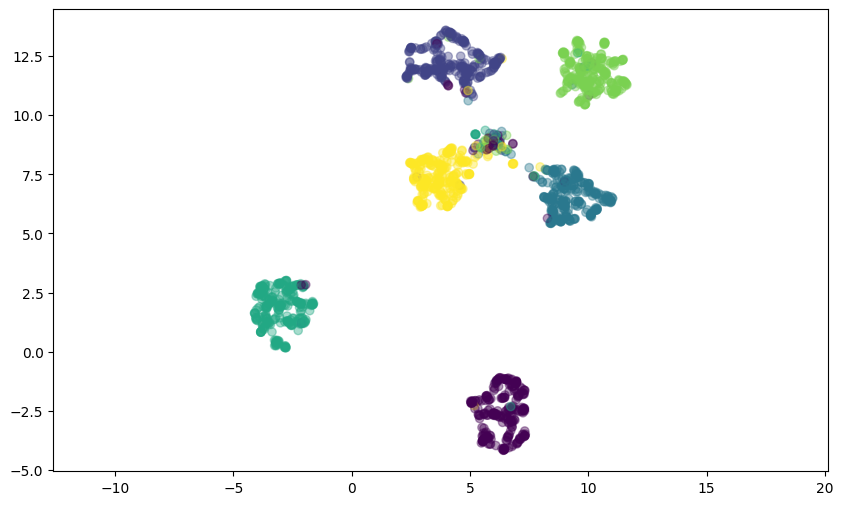

In [306]:
plt.figure(figsize=(10,6))
plt.scatter(embedding.embedding_[:, 0], embedding.embedding_[:, 1], alpha=0.4, c=nodes_labels.real_cluster_modified, cmap='viridis')
plt.gca().set_aspect('equal', 'datalim')
plt.show()

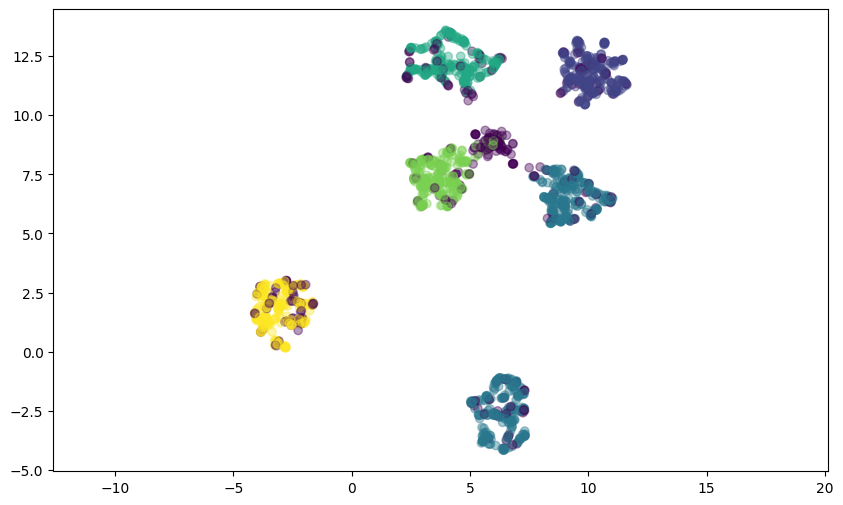

In [275]:
plt.figure(figsize=(10,6))
plt.scatter(embedding.embedding_[:, 0], embedding.embedding_[:, 1], alpha=0.4, c=nodes_labels.hdbscan, cmap='viridis')
plt.gca().set_aspect('equal', 'datalim')
plt.show()